# Importing libraries

In [20]:
import pandas as pd
import numpy as np
import re
import pickle
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from contractions import contractions_dict


# Example emoji dictionary
emoji_dict = {
    ":thumbs_up:": "👍",
    ":smile:": "😊",
    ":heart:": "❤️",
    # Add more as needed
}

def emojize(text):
    pattern = re.compile(r'(:\w+:)')
    return pattern.sub(lambda x: emoji_dict.get(x.group(), x.group()), text)

# Test the custom emojize function
print(emojize('Python is :thumbs_up:'))

print(pd.__version__)
print(np.__version__)


Python is 👍
1.4.4
1.21.5


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sondaryachauhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sondaryachauhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sondaryachauhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sondaryachauhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


In [22]:
df = pd.read_csv("cyberbullying_tweets.csv")

In [23]:
df

tweet_text cyberbullying_type
0      In other words #katandandre, your food was cra...  not_cyberbullying
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
...                                                  ...                ...
47687  Black ppl aren't expected to do anything, depe...          ethnicity
47688  Turner did not withhold his disappointment. Tu...          ethnicity
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity

[47692 rows x 2 columns]

# Exploratory Data Analysis (EDA)

In [24]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [25]:
len(df)

47692

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [27]:
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)


In [28]:
np.sum(df.isnull())

tweet_text            0
cyberbullying_type    0
dtype: int64

In [29]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'label'})

In [30]:
text, label = list(df['text']), list(df['label'])

In [31]:
df.sample(5)

text      label
19824  The same speech of idiot Muslim Brotherhoods. ...   religion
22959  There's a difference between not liking trump ...   religion
37364  hot girls pretending they were bullied in high...        age
45679  @SloppyTopHoe I'm not looking for anything dum...  ethnicity
32260                       noo im a middle school bully        age

In [32]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

df['label_encoded'] = labelencoder.fit_transform(df['label'])

In [33]:
df[['label', 'label_encoded']].value_counts()

label              label_encoded
religion           4                7998
age                0                7992
gender             2                7973
ethnicity          1                7961
not_cyberbullying  3                7945
dtype: int64

# Data Cleaning

In [34]:
df['text'] = df['text'].str.lower()
df.tail()

text      label  \
47687  black ppl aren't expected to do anything, depe...  ethnicity   
47688  turner did not withhold his disappointment. tu...  ethnicity   
47689  i swear to god. this dumb nigger bitch. i have...  ethnicity   
47690  yea fuck you rt @therealexel: if youre a nigge...  ethnicity   
47691  bro. u gotta chill rt @chillshrammy: dog fuck ...  ethnicity   

       label_encoded  
47687              1  
47688              1  
47689              1  
47690              1  
47691              1

In [35]:
STOPWORDS = set(stopwords.words('english'))

In [36]:
df.sample(5)

text      label  \
31820                  ah, so you were the school bully?        age   
18299  jihad was against evil thoughts & injustice by...   religion   
11811  audience revolts after margaret cho jokes abou...     gender   
11825  rt @sales88194029: colin says the meat in the ...     gender   
42826  “@tayyoung_: fuck obama, dumb ass nigger” &lt;...  ethnicity   

       label_encoded  
31820              0  
18299              4  
11811              2  
11825              2  
42826              1

In [37]:
def contractions(text):
    expanded_words = []   
    for word in text.split():
        if word in contractions_dict:
            expanded_words.append(contractions_dict[word])
        else:
            expanded_words.append(word)
    return " ".join(expanded_words)

df['text'] = df['text'].apply(lambda text: contractions(text))

In [38]:
df.sample(5)

text              label  \
38502  my sister in law was friends with the girl who...                age   
13834  @thisisanorder @his_butler_gay do not make rap...             gender   
6519   , frio é bulling contra os solteiros... agnt q...  not_cyberbullying   
44645  you 2 dumb ugly nigger name wayne positive tra...          ethnicity   
11391  rt @joelizaharrison: @lyall seriously? where e...             gender   

       label_encoded  
38502              0  
13834              2  
6519               3  
44645              1  
11391              2

In [39]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [40]:
df.sample(5)

text              label  \
6570   @sugarpopjapsmoe @lizjocson @francehuelgas ate...  not_cyberbullying   
9467   no i'm sorry i did not hear my friend who i wa...             gender   
17762  the communists. the communists are always the ...           religion   
39825  rt @yannnaas: cunt. rt @tayyoung_: fuck obama,...          ethnicity   
5484             @tobyfee @justkelly_ok #hipchat forever  not_cyberbullying   

       label_encoded  
6570               3  
9467               2  
17762              4  
39825              1  
5484               3

In [42]:
emoji_dict = {
    ":thumbs_up:": "👍",
    ":smile:": "😊",
    ":heart:": "❤️",
    # Add more emojis and their corresponding text representations as needed
}

def emojize(text):
    pattern = re.compile(r'(:\w+:)')
    return pattern.sub(lambda x: emoji_dict.get(x.group(), x.group()), text)

def strip_emoji(text):
    return emojize(text)

# Assuming df['text'] is a column in your DataFrame df
df['text'] = df['text'].apply(strip_emoji)

In [43]:
df.sample(5)

text              label  \
4029   @discerningmumin examples being death for apos...  not_cyberbullying   
42607  rt @worldshiphop: rt if you still hate this ni...          ethnicity   
7028   kat and andre make me want to punch happy thin...  not_cyberbullying   
466                                  @kylieminogue @muse  not_cyberbullying   
21817  did you feel the pain? perhaps so many times w...           religion   

       label_encoded  
4029               3  
42607              1  
7028               3  
466                3  
21817              4

In [44]:
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in STOPWORDS]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14)
    return text

df['text'] = df['text'].apply(lambda text: strip_all_entities(text))

In [45]:
df.sample(5)

text     label  \
34687  hate whole middle school class like let us bul...       age   
11781                rt ten things feminists really care    gender   
20447  yeah person remotely religious scared extreme ...  religion   
34619  guess conceded self awareness idk really prett...       age   
16414  americans iraq allow iraqis elect leadership s...  religion   

       label_encoded  
34687              0  
11781              2  
20447              4  
34619              0  
16414              4

In [46]:
def clean_hashtags(text):
    tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
    cleaned_tweet = " ".join(word.strip() for word in re.split('#|_', tweet))
    return cleaned_tweet

df['text'] = df['text'].apply(lambda text: clean_hashtags(text))

In [47]:
df.sample(5)

text              label  \
9236   1 every word use comes 1600s bothered look ori...             gender   
790                                                       not_cyberbullying   
18630  ban radical pissslam save humanity radical jih...           religion   
34368  annoying ass fucking boys using one clout u kn...                age   
2557    another plr provider discovery thanks connection  not_cyberbullying   

       label_encoded  
9236               2  
790                3  
18630              4  
34368              0  
2557               3

In [48]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

df['text'] = df['text'].apply(lambda text: remove_mult_spaces(text))

In [49]:
df.sample(5)

text              label  \
219                                  hahaha see doubtful  not_cyberbullying   
43503  biden even president yet president past 4 year...          ethnicity   
23036  know christian woman whose husband man ever se...           religion   
44506  2020 blackpink wins one song got highest pak g...          ethnicity   
33421  transphobic bullies learn afraid chill honey s...                age   

       label_encoded  
219                3  
43503              1  
23036              4  
44506              1  
33421              0

In [50]:
def clean_repeating_characters(text):
    return re.sub(r'(.)1+', r'1', text)

df['text'] = df['text'].apply(lambda text: clean_repeating_characters(text))

In [51]:
df.sample(5)

text              label  \
1715                          toxic gasses belonged isis  not_cyberbullying   
33385  grew life right went private school grew amazi...                age   
7638   within three weeks missed 4 classes total15 ab...  not_cyberbullying   
10932                                           u insane             gender   
9941   im fighting bitches one older female cousins m...             gender   

       label_encoded  
1715               3  
33385              0  
7638               3  
10932              2  
9941               2

In [52]:
def clean_numeric(text):
    return re.sub('[0-9]+', '', text)
    
df['text'] = df['text'].apply(lambda text: clean_numeric(text))

In [53]:
df.sample(5)

text     label  \
19202  worry sir alwaysproud u first one world raise ...  religion   
12523   females think dating pussy cute stuff make pussy    gender   
12338  rt im sexist anything take female rappers seri...    gender   
20507  think jihad kaafir jajia tax kaafir slaves shi...  religion   
9759   omg guys heard rumors trump going kill gays  k...    gender   

       label_encoded  
19202              4  
12523              2  
12338              2  
20507              4  
9759               2

In [54]:
df["text"].duplicated().sum()

1033

In [55]:
df.drop_duplicates("text", inplace=True)

In [56]:
df[['label', 'label_encoded']].value_counts()

label              label_encoded
religion           4                7946
age                0                7894
ethnicity          1                7743
not_cyberbullying  3                7641
gender             2                7612
dtype: int64

In [57]:
text_len = []
for text in df.text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [58]:
df['text_len'] = text_len

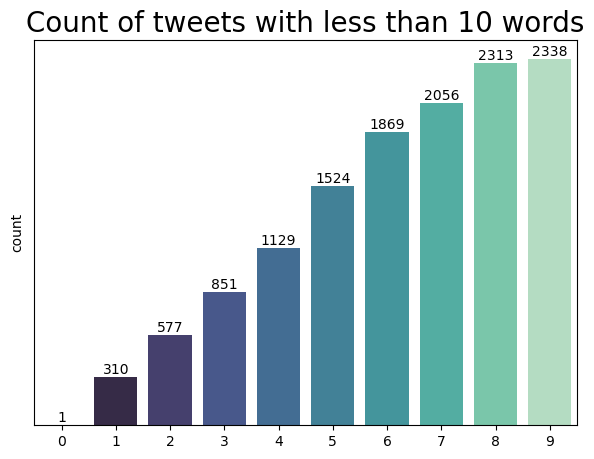

In [59]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [60]:
df.sort_values(by=['text_len'], ascending=False)

text              label  \
44035  black white trying live like nigger pahahahaha...          ethnicity   
45165  fuck obama dumb ass nigger bitch ltthis whore ...          ethnicity   
1317   researchers push import top antibullying progr...  not_cyberbullying   
33724  feel guilty killing feel guilty enjoyed tormen...                age   
47037  sooo mad rt fuck obama dumb nigger im going sw...          ethnicity   
...                                                  ...                ...   
1702                                               laura  not_cyberbullying   
15491                                              troll             gender   
1691                                               shhhh  not_cyberbullying   
6178                                                kill  not_cyberbullying   
10                                                        not_cyberbullying   

       label_encoded  text_len  
44035              1       182  
45165              1       156  
1317               3       139  
33724              0       134  
47037              1       123  
...              ...       ...  
1702               3         1  
15491              2         1  
1691               3         1  
6178               3         1  
10                 3         0  

[38836 rows x 4 columns]

In [61]:
df = df[df['text_len'] > 3]
df = df[df['text_len'] < 100]

In [62]:
df.sample(10)

text              label  \
21559  bombed hitler various dictators refused slaves...           religion   
9987   bruce said nword several times made jokes ever...             gender   
45393                   colored wonder u cant see racism          ethnicity   
1381           could repeat job getting recruits meaning  not_cyberbullying   
17059  u imagine never happened future still u imagin...           religion   
18735  embraced radical islam american jew support be...           religion   
34159   foot tall girl high school also androgynous l...                age   
8227   men lack selfawareness women complicated notse...             gender   
44818  dumb fucklol thats nab dummysmh rt nba stands ...          ethnicity   
8525   discover manipulation create sexist groups scr...             gender   

       label_encoded  text_len  
21559              4        11  
9987               2        16  
45393              1         6  
1381               3         6  
17059              4        32  
18735              4         8  
34159              0        15  
8227               2         6  
44818              1        11  
8525               2        13

In [63]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)

In [64]:
st = nltk.PorterStemmer()

def text_stemming(text):
    text = [st.stem(word) for word in text]
    return text

df['text'] = df['text'].apply(lambda text: text_stemming(text))

In [65]:
lm = nltk.WordNetLemmatizer()

def text_lemmatization(text):
    text = [lm.lemmatize(word) for word in text]
    return text

df['text'] = df['text'].apply(lambda text: text_lemmatization(text))

In [66]:
df.sample(5)['text']

8034     [rt, woman, report, soccer, saturday, got, clu...
47622    [blm, againthey, understand, douglas, spokesma...
16111    [johnson, idiot, stupid, joke, laugh, starma, ...
21418     [rt, dem, parti, kick, god, curb, defend, islam]
43021    [believ, u, incit, fear, racism, violent, prot...
Name: text, dtype: object

# WordCloud

In [67]:
wc_0_df = df
wc_0_df = wc_0_df[wc_0_df['label'] != 'not_cyberbullying']
wc_0_df = wc_0_df['text'].apply(lambda x: " ".join(x))

In [68]:
wc_0_df.sample(5)

38141    mad girl use bulli school actual peak secondar...
18319         badr brigad liber anyon simpli differ flavor
12798                    n yeah u hate boy coz u r lesbian
39010    girl bulli high school went beauti school amp ...
8150     say bad thing woman harass say bad thing gay p...
Name: text, dtype: object

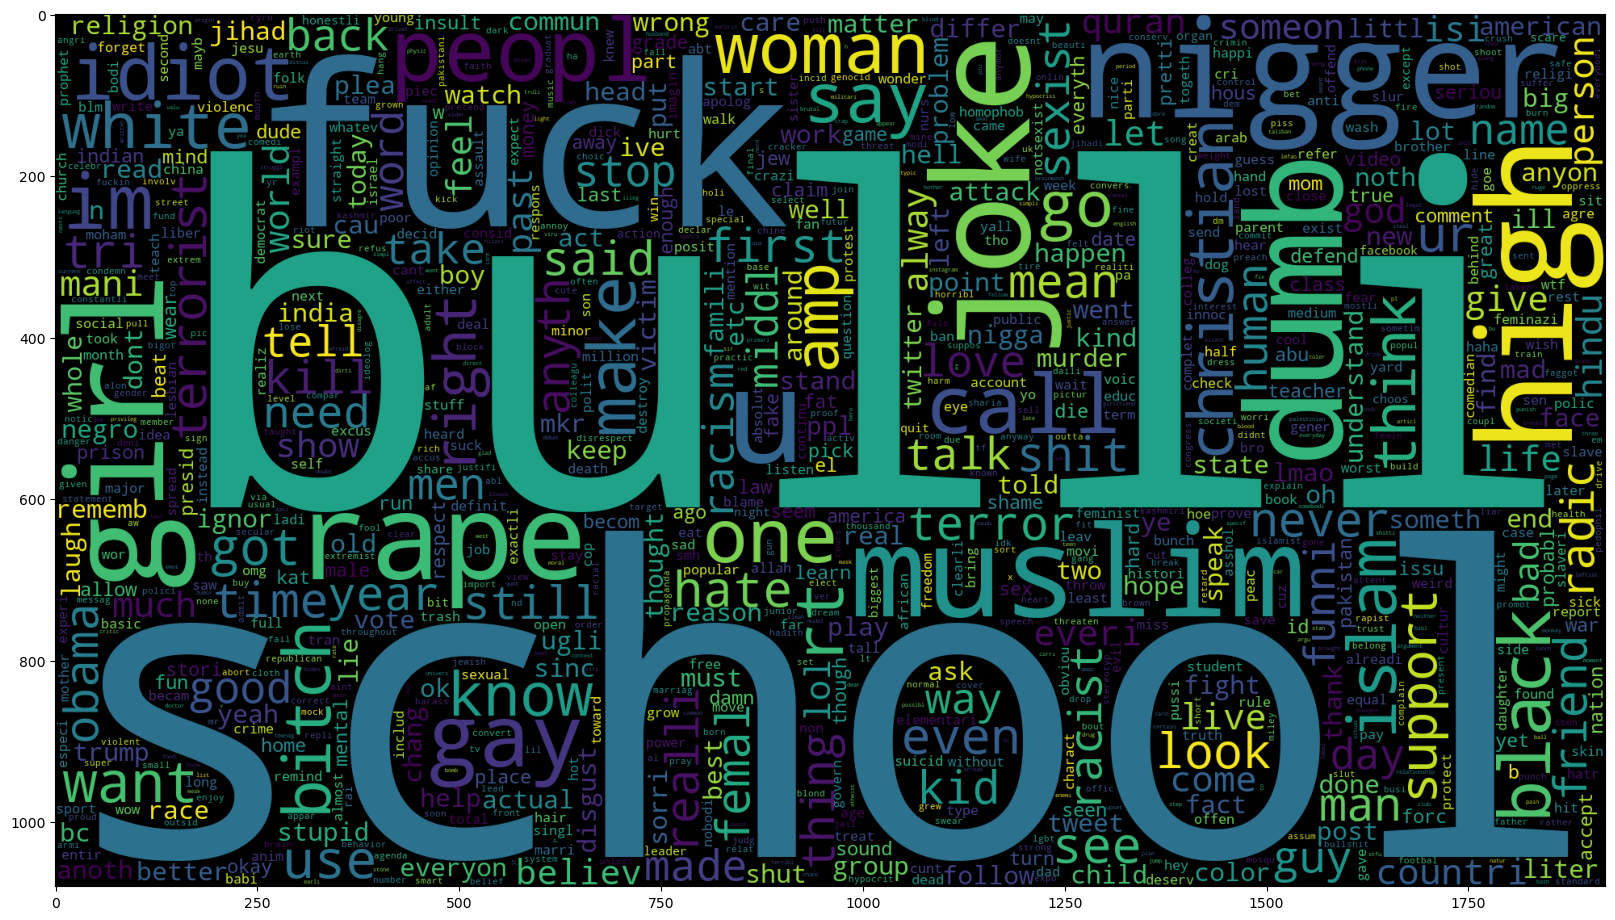

In [69]:
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=1000, width= 1920, height= 1080, 
                collocations= False).generate(' '.join(wc_0_df))
plt.imshow(wc)

In [70]:
wc_1_df = pd.read_csv("cyberbullying_tweets.csv")
wc_1_df = wc_1_df[wc_1_df['cyberbullying_type'] != "not_cyberbullying"]
wc_1_df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

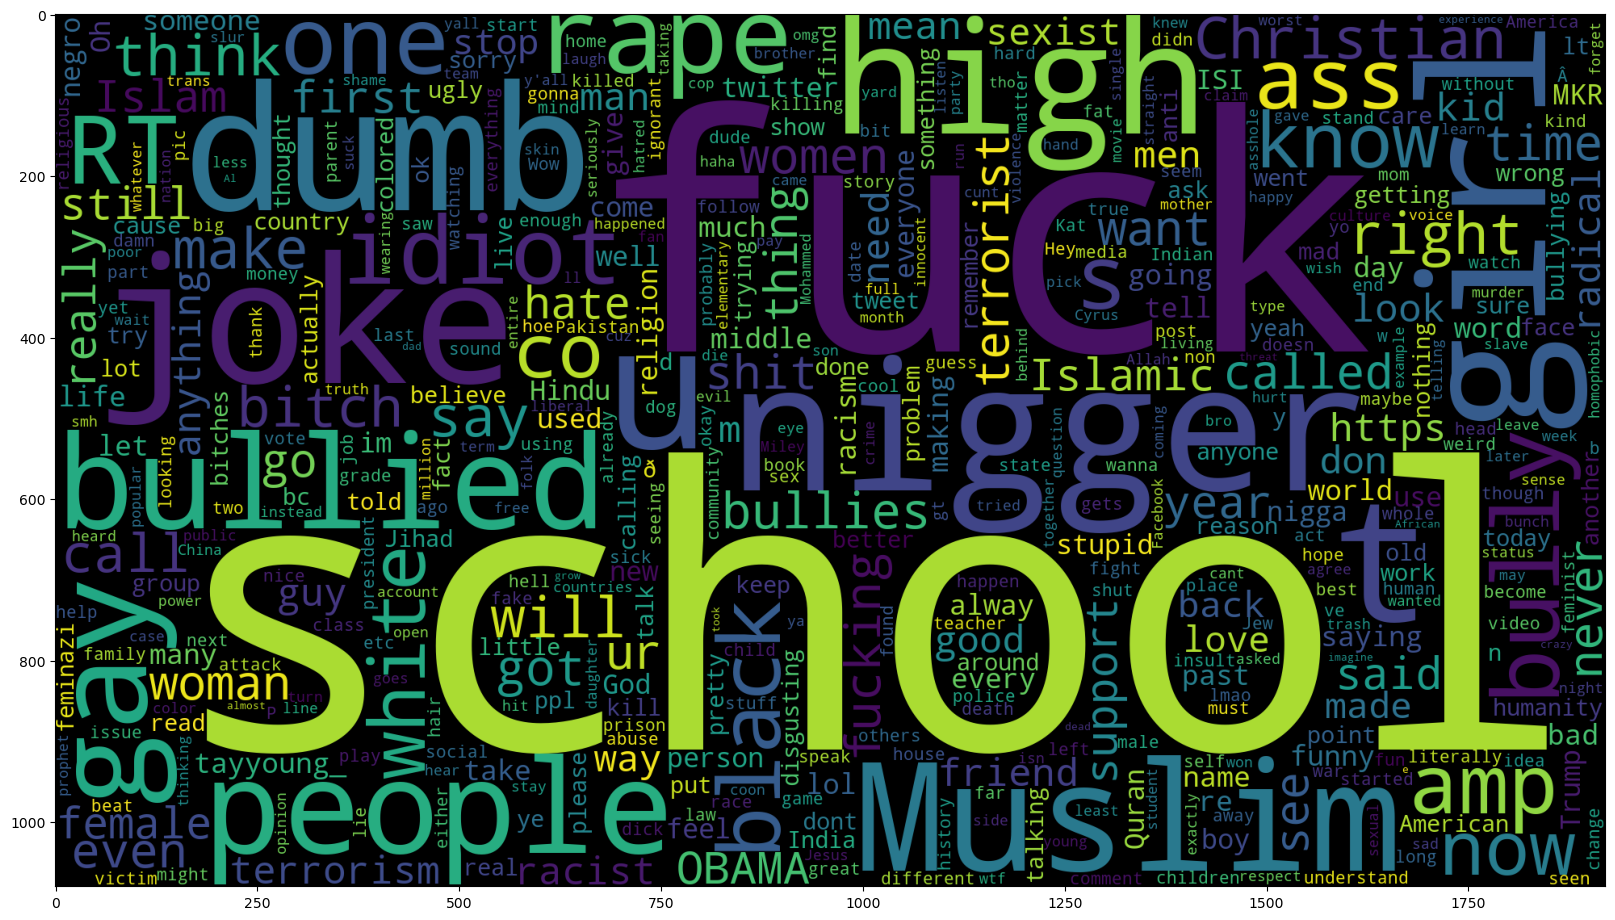

In [71]:
plotting_data = wc_1_df['tweet_text']
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=500, width= 1920, height= 1080, 
                collocations= False).generate(' '.join(plotting_data))
plt.imshow(wc)

In [72]:
wc_2_df = wc_1_df[wc_1_df['cyberbullying_type'] != "not_cyberbullying"]
wc_2_df = wc_1_df[wc_1_df['cyberbullying_type'] != "other_cyberbullying"]
wc_2_df['cyberbullying_type'].value_counts()

religion     7998
age          7992
gender       7973
ethnicity    7961
Name: cyberbullying_type, dtype: int64

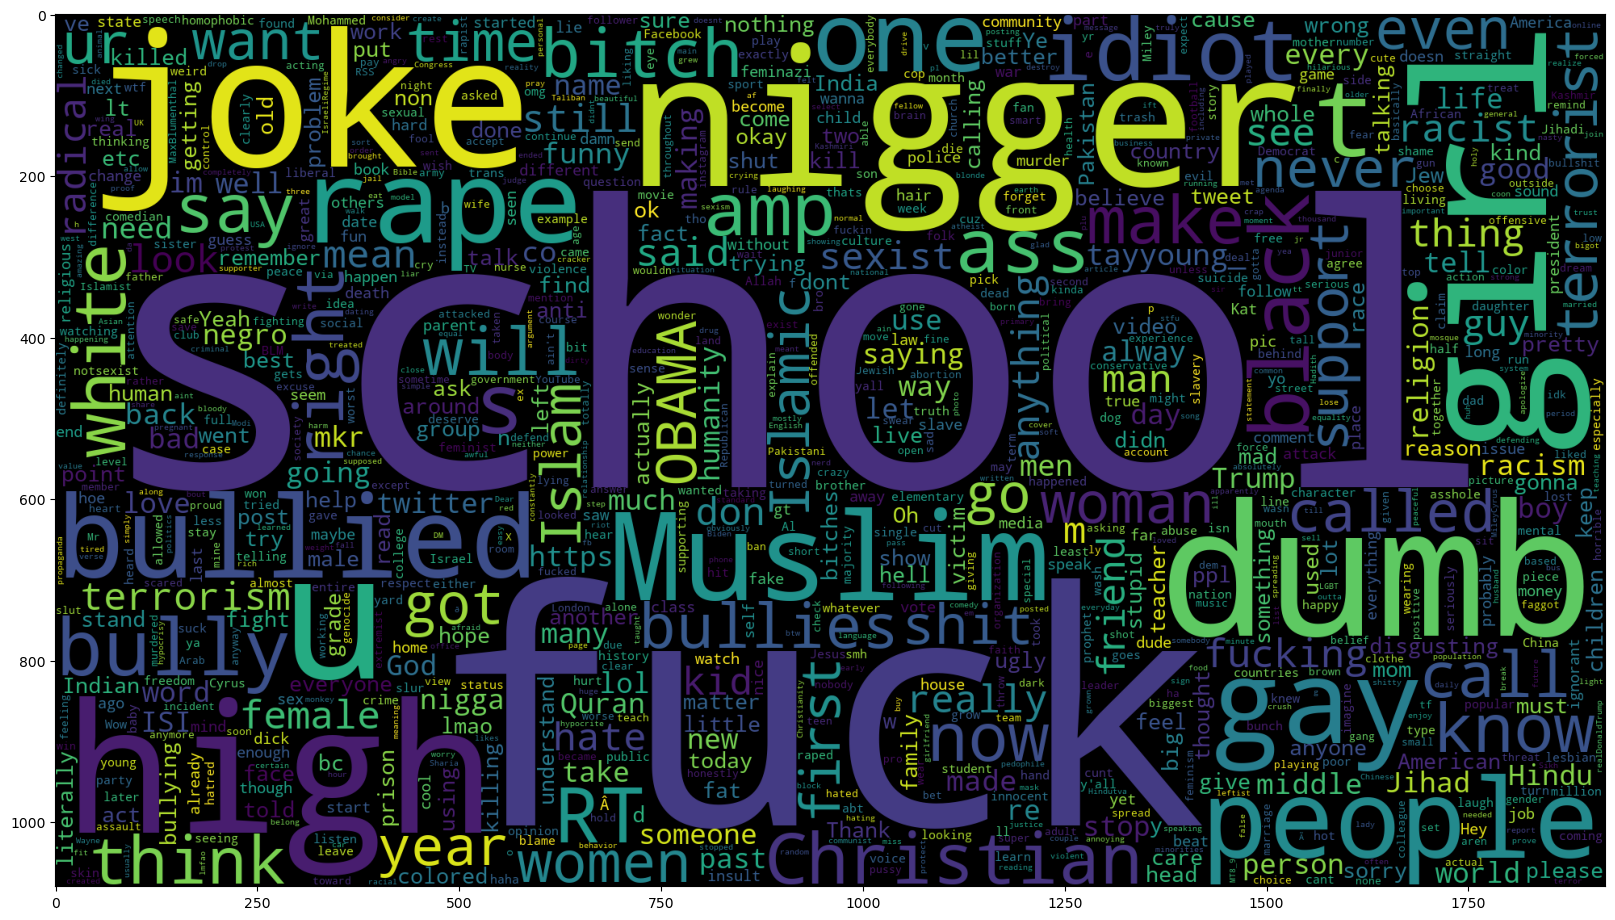

In [73]:
plotting_data = wc_2_df['tweet_text']
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=1000, width= 1920, height= 1080, 
                collocations= False).generate(' '.join(plotting_data))
plt.imshow(wc)

In [74]:
df.sample(5)

text     label  \
14485  [yeah, absolut, ill, pick, cover, gay, marriag...    gender   
16620  [hey, cannot, say, immor, christian, support, ...  religion   
33088  [pumpkin, night, volum, cover, author, kill, m...       age   
38540  [go, bulli, nigga, school, call, name, like, w...       age   
22480  [see, comment, everi, post, foolish, india, se...  religion   

       label_encoded  text_len  
14485              2        14  
16620              4        17  
33088              0        24  
38540              0         8  
22480              4        24

# Model Creation

In [75]:
df['text'] = df['text'].apply(lambda x : " ".join(x))

In [76]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features= 500000)

tf_transformer = tfidf.fit(df['text'])
X_tf = tf_transformer.transform(df['text'])

In [77]:
X_tf

<37088x325281 sparse matrix of type '<class 'numpy.float64'>'
	with 988425 stored elements in Compressed Sparse Row format>

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_tf, df['label'], test_size=0.20, stratify=df['label'], random_state=42)

In [79]:
y_train.value_counts()

religion             6311
age                  6269
ethnicity            6162
gender               5842
not_cyberbullying    5086
Name: label, dtype: int64

In [80]:
from imblearn.over_sampling import SMOTE
vc = y_train.value_counts()
while (vc[0] != vc[4]) or (vc[0] !=  vc[2]) or (vc[0] !=  vc[3]) or (vc[0] !=  vc[1]):
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    vc = y_train.value_counts()

y_train.value_counts()

ethnicity            6311
age                  6311
not_cyberbullying    6311
gender               6311
religion             6311
Name: label, dtype: int64

## Model Training

### SVM

In [81]:
svm_clf = SVC(kernel= 'linear', C = 1)
svm_clf.fit(X_train, y_train)

SVC(C=1, kernel='linear')

### Naive Bayes

In [82]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

### K Nearest Neighbor

In [83]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

### Random Forest

In [84]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

## Model Evaluation

### SVM

In [85]:
svm_predictions  = svm_clf.predict(X_test)
print(classification_report(y_test, svm_predictions))

                   precision    recall  f1-score   support

              age       0.97      0.98      0.97      1567
        ethnicity       0.98      0.98      0.98      1541
           gender       0.95      0.87      0.91      1461
not_cyberbullying       0.79      0.87      0.83      1271
         religion       0.96      0.95      0.95      1578

         accuracy                           0.93      7418
        macro avg       0.93      0.93      0.93      7418
     weighted avg       0.94      0.93      0.93      7418



In [86]:
svm_cv_score = cross_val_score(svm_clf,X_train, y_train, cv=3)
print('Cross validation score: ', svm_cv_score.mean())

Cross validation score:  0.9344320716347821


### Naive Bayes

In [87]:
nb_predictions = nb_clf.predict(X_test)
print(classification_report(y_test, nb_predictions))

                   precision    recall  f1-score   support

              age       0.83      0.99      0.90      1567
        ethnicity       0.91      0.94      0.93      1541
           gender       0.90      0.87      0.89      1461
not_cyberbullying       0.88      0.48      0.62      1271
         religion       0.84      0.98      0.90      1578

         accuracy                           0.87      7418
        macro avg       0.87      0.85      0.85      7418
     weighted avg       0.87      0.87      0.86      7418



In [88]:
nb_cv_score = cross_val_score(nb_clf,X_train, y_train, cv=3)
print('Cross validation score: ', nb_cv_score.mean())

Cross validation score:  0.8739980726358892


### K Nearest Neighbor

In [89]:
knn_pred = knn_clf.predict(X_test)
print(classification_report(y_test, knn_pred))

                   precision    recall  f1-score   support

              age       0.98      0.68      0.80      1567
        ethnicity       0.98      0.74      0.84      1541
           gender       0.89      0.77      0.83      1461
not_cyberbullying       0.31      0.95      0.47      1271
         religion       0.94      0.04      0.07      1578

         accuracy                           0.62      7418
        macro avg       0.82      0.63      0.60      7418
     weighted avg       0.84      0.62      0.60      7418



In [90]:
knn_cv_score = cross_val_score(knn_clf,X_train, y_train, cv=3)
print('Cross validation score: ', knn_cv_score.mean())

Cross validation score:  0.6983067664428374


### Random Forest

In [91]:
rf_pred = rf_clf.predict(X_test)
print(classification_report(y_test, rf_pred))

                   precision    recall  f1-score   support

              age       0.98      0.98      0.98      1567
        ethnicity       0.99      0.98      0.99      1541
           gender       0.96      0.85      0.90      1461
not_cyberbullying       0.79      0.89      0.84      1271
         religion       0.96      0.96      0.96      1578

         accuracy                           0.94      7418
        macro avg       0.94      0.93      0.93      7418
     weighted avg       0.94      0.94      0.94      7418



In [92]:
rf_cv_score = cross_val_score(rf_clf,X_train, y_train, cv=3)
print('Cross validation score: ', rf_cv_score.mean())

Cross validation score:  0.9373158810417292


## Saving trained models

In [129]:
pickle.dump(svm_clf,open('svm_clf.pkl','wb'))
pickle.dump(nb_clf,open('nb_clf.pkl','wb'))
pickle.dump(knn_clf,open('knn_clf.pkl','wb'))
pickle.dump(rf_clf,open('rf_clf.pkl','wb'))